In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
## All the properties and types

class ROOM_TYPE:
    EMPTY = 1
    MESSY = 2
    
class DISPLAY_STATUS:
    DIRTY = [0.0, 0.0, 0.0] # RGB color = Black
    CLEAN = [1.0, 1.0, 1.0] # RGB color = White 
    ROOMBA = [0.0, 0.0, 1.0] # RGB color = Blue
    OBSTACLE = [1.0, 0.0, 0] # RGB color = Red

class CLEANING_STATUS:
    DIRTY = 0
    CLEAN = 1
    OBSTACLE = -1
    ROOMBA = 2

In [3]:
DISPLAY = False

class Roomba:
    def __init__(self, ini_x=0, ini_y=0, direction=(0,1),
                 bounce_threshold = 0.2, neighborhood="MOORE"):
        '''
            Sets up a Roomba Object
            
            Input:
            
            * ini_x (int) The home x-coordinates of the roomba where the charger is located.
              Default = 0
            
            * ini_y (int) The home y-coordinates of roomba where the charger is located
              Default = 0
            
            * direction (set) The direction of movement of roomba
              Default = (0, 1)
            
            * bounce_threshold (float) The probability of switching direction when using
                straight and random strategy. Default = 0.2
                
            * neighborhood (string) "MOORE" or "VON NEUMANN" The neighborhood or possible 
                moves that Roomba can make. Default = "MOORE"
             
            Attributes:
            
            * moves (list) stores all the moves that roomba can make

        '''
        self.ini_x = ini_x
        self.ini_y = ini_y
        self.x = ini_x # current x-coordinate of Roomba
        self.y = ini_y # Current y-coordinate fo Roomba
        self.direction = direction
        self.bounce_threshold = bounce_threshold
        self.neighborhood = neighborhood
        
        # Generating moves
        self.moves = self.generate_moves()
       
    def generate_moves(self):
        '''
            Generates a list of move, based on the neighborhood Roomba takes
        '''
        if self.neighborhood == "MOORE":
            return ([1, 1], [1, -1], [-1, 1], [-1, -1], 
                    [0, 1], [0, -1], [1, 0], [-1, 0])
        else:
            return ([0, 1], [0, -1], [1, 0], [-1, 0])
    
    def set_neighborhood(self, neighborhood):
        '''
            Sets neighboorhood and genrates new moves
            
            Input:
            
            * neighborhood (string) "MOORE" or "VON NEUMANN" The neighborhood or possible 
                moves that Roomba can make
        '''
        
        self.neighborhood = neighborhood
        self.moves = self.generate_moves()
        
    
    def set_location(self, x, y):
        '''
            Updates the location of Roomba
        '''
        self.x = x
        self.y = y
        
    def get_location(self):
        '''
            Returns the coordinates of Roomba
        '''
        return x, y

    def update_direction(self, dx, dy):
        '''
            Updates the direction or next updates for Roomba
        '''
        self.direction = (dx, dy)
    

    
        
class RoomSimulation:
    def __init__(self, room_size=(20,20), room_type=ROOM_TYPE.EMPTY, 
                 num_obstacles=20, roomba_params={}):
        
        '''
        Initialize the room and simulator.
        
        Input:
        
        * room_size (list) stores the length and with of the room.
            Default: (20, 20)
        
        * room_type (ROOM_TYPE) The type of the room
            Default: ROOM_TYPE.EMPTY
        
        * num_obstacles (int) Number of obstacles to randomly generate
            Default: 20
        
        * roomba_params (dict) The parameters for initializing Roomba
            Default: {}
        
        
        Attributes:
        
        * room_display_matrix (2*2 matrix) Stores the RBG values of colors in each cell
        
        * room_matrix (2*2 matrix) stores the status of each cell in the room
        
        * room_size (list) size of the room
        
        * roomba (Roomba) The roomba object
        
        * timesteps (int) The timesteps the simulation has progressed
        
        * strategy (func) The strategy roomba is using
        
        * strategies (dict) The list of all strategies available
        
        
        
        '''
        self.room_display_matrix = np.zeros(room_size)
        self.room_matrix = np.zeros(room_size)
        self.room_size = room_size
        self.room_type = room_type
        self.roomba = Roomba(**roomba_params)
        self.num_obstacles = num_obstacles
        
        self.timesteps = 0
        self.steps = [] #
        self.timesteps_for_complete_cleaning = 0
        
        self.strategy = self.strategy_straight_and_random
        
        self.strategies = {
            'random_move': self.strategy_random_move,
            'straight_and_random': self.strategy_straight_and_random,
            'check_dirty': self.strategy_check_dirty
        }
        
        self.setup_room()
    
    
    def setup_room(self):
        '''
            Setups the room based on the matrix 
        '''
        
        if self.room_type == ROOM_TYPE.EMPTY:
            # If room is empty fill evertyhing as dirty
            self.room_display_matrix = np.full((*self.room_size, 3), DISPLAY_STATUS.DIRTY)
            self.room_matrix = np.full(self.room_size, CLEANING_STATUS.DIRTY)
            
            # Updating initial homebase of ROOMBA
            self.update_matrix(self.roomba.ini_x, self.roomba.ini_y, 
                               CLEANING_STATUS.ROOMBA, DISPLAY_STATUS.ROOMBA)
        
        elif self.room_type == ROOM_TYPE.MESSY:
            # If room is messy randomly generate obstacles
            self.room_display_matrix = np.full((*self.room_size, 3), DISPLAY_STATUS.DIRTY)
            self.room_matrix = np.full(self.room_size, CLEANING_STATUS.DIRTY)
            
            # Updating initial homebase of ROOMBA
            self.update_matrix(self.roomba.ini_x, self.roomba.ini_y, 
                               CLEANING_STATUS.ROOMBA, DISPLAY_STATUS.ROOMBA)
            
            # Generating random obstacles
            self.generate_random_obstacles(self.num_obstacles)
            
            self.num_obstacles = len(np.where(self.room_matrix 
                                     == CLEANING_STATUS.OBSTACLE)[0])
            
    
    def generate_random_obstacles(self, num_obstacles):
        '''
            Creates obstacles in the room
            
            Input:
            
            * num_obstacles: Number of obstacles to create
        '''
        
        # Choosing all the spots possible for creating obstacles
        # Obstacles will replace any cell
        choices = [(i, j) for i in range(self.room_size[0]) for j in range(self.room_size[1])]
        
        # Deleting the charging station of Roomba
        choices.remove((self.roomba.ini_x, self.roomba.ini_y))
        
        # Shuffling the array
        random.shuffle(choices)

        num_obstacles_generated = 0
        
        while num_obstacles_generated < num_obstacles and len(choices) >=0:
            obs_x, obs_y = choices.pop()
            if self.room_matrix[obs_x, obs_y] != CLEANING_STATUS.OBSTACLE:
                self.add_obstacle(obs_x, obs_y)
                num_obstacles_generated += 1
                
    def generate_obstacles(self, list_obstacles):
        '''
            Creates obstacles in the given coordinates
            
            Input: 
            
            * list_obstacle (list) the list of coordinates for obstacles to be created
        '''
        for x, y in list_obstacles:
            self.add_obstacle(x, y)
            
            
    def add_obstacle(self, obs_x, obs_y):
        '''
            Adds obstacles to a given coordinates in the matrix
            
            Input:
            
            * obs_x -> The x-coordinates of the obstacle
            
            * obs_y -> The y-coordinates of the obstacle
        '''
        self.update_matrix(obs_x, obs_y, 
                                   CLEANING_STATUS.OBSTACLE, 
                                   DISPLAY_STATUS.OBSTACLE)
        
        
    def change_strategy(self, strategy_name):
        '''
            Changes the simulation strategy
            
            Input:
            
            * strategy_name (string) The name of the strategy
        '''
        self.strategy = self.strategies[strategy_name]
            
   
    def update_matrix(self, x, y, cleaning_status, display_status):
            '''
                Updates both display matrix and internal matrix for storing status

                Input:
                * x (int) The x-coordinate on the room matrix to update

                * y (int) The y-coordinate on the room matrix to update

                * cleaning_status (CLEANING_STATUS.type) The cleaning status of the
                    cell to be updated

                * display_status (DISPLAY_STATUS.type) The display status of the
                    cell to be updated

            '''
            self.room_matrix[x, y] = cleaning_status
            self.room_display_matrix[x, y] = display_status
    
    def step(self):
        '''
            Moves the roomba one step using the selected strategy
        '''
        
        # getting next moves from selected strategy
        dx, dy = self.strategy()
        
        # Updating next moves
        next_x = self.roomba.x + dx
        next_y = self.roomba.y + dy
        
        # Update roomba's location
        self.roomba.set_location(next_x, next_y)
        
        # Updating both display and computational matrix
        self.update_matrix(next_x, next_y,
                         CLEANING_STATUS.CLEAN, DISPLAY_STATUS.CLEAN)
        
        # Update timesteps
        self.timesteps += 1
        if (self.calc_cleaned_area() == 1.0 
            and self.timesteps_for_complete_cleaning != 1):
            self.timesteps_for_complete_cleaning = self.timesteps
        
    
    
    ########
    # Strategies
    
    def strategy_random_move(self):
        '''
            Randomly moves the roomba to a new neighborhood cell
            
            Output:
            
            * (list) (dx, dy) The direction to update for both x and y coordinates
        '''
        moves = list(self.roomba.moves)
        
        # Shuffling the moves
        random.shuffle(moves)
        
        cur_x = self.roomba.x
        cur_y = self.roomba.y
        
        while len(moves) > 0:
            dx, dy = moves.pop()
            
            if ((0 <= (cur_x + dx) < self.room_size[0]) 
                and (0 <= (cur_y + dy) < self.room_size[1]) 
                and self.room_matrix[cur_x + dx, cur_y + dy] != CLEANING_STATUS.OBSTACLE
                and self.room_matrix[cur_x + dx, cur_y + dy] != CLEANING_STATUS.ROOMBA):
                break
            
            if len(moves) == 0:
                # Roomba is stuck as no direction to move
                return 0, 0
        
        return dx, dy
    
    def strategy_straight_and_random(self):
        '''
            The roomba moves in given direction until it hits an obstacle or its
            home when it randomly changes direction.
            It also randomly changes direction with a probability less than
            bounce threshold.
            
            Output:
            
            * (list) (dx, dy) The direction to update for both x and y coordinates
        '''
        cur_x = self.roomba.x
        cur_y = self.roomba.y
        
        dx, dy = self.roomba.direction
        
        if random.random() < self.roomba.bounce_threshold:
            # If the random number is less than the bounce threshold, it will
            # switch direction
            dx, dy = self.strategy_random_move()
            self.roomba.update_direction(dx, dy)
        else:
            if ((0 <= (cur_x + dx) < self.room_size[0]) 
                and (0 <= (cur_y + dy) < self.room_size[1])
                and self.room_matrix[cur_x + dx, cur_y + dy] != CLEANING_STATUS.OBSTACLE
                and self.room_matrix[cur_x + dx, cur_y + dy] != CLEANING_STATUS.ROOMBA):
                return dx, dy
            else:
                dx, dy = self.strategy_random_move()
                self.roomba.update_direction(dx, dy)
        
        return dx, dy
    
    
    def strategy_check_dirty(self):
        '''
            - Checks for the dirt in its neighborhood.
            
            - If it finds dirt, then goes to dirty cell. If no neighboring cells are 
              dirty, randomly chooses a empty cell to move.
              
              
            Output:
            
            * (list) (dx, dy) The direction to update for both x and y coordinates
        '''
        
        # Get moves that roomba can make
        moves = list(self.roomba.moves)
        
        # Shuffling the moves
        random.shuffle(moves)
        
        available_moves = []
        cur_x = self.roomba.x
        cur_y = self.roomba.y
        
        while len(moves) > 0:
            dx, dy = moves.pop()
            
            if ((0 <= (cur_x + dx) < self.room_size[0]) 
                and (0 <= (cur_y + dy) < self.room_size[1])):
                    
                if self.room_matrix[cur_x + dx, cur_y + dy] == CLEANING_STATUS.DIRTY:
                    return dx, dy
                else:
                    if (self.room_matrix[cur_x + dx, cur_y + dy] != CLEANING_STATUS.OBSTACLE
                    and self.room_matrix[cur_x + dx, cur_y + dy] != CLEANING_STATUS.ROOMBA):
                        # If the direction is movable but not clean store it in different array
                        available_moves.append([dx, dy])
            
            if len(moves) == 0 and len(available_moves) == 0:
                # Roomba is stuck as no direction to move
                return 0, 0
        
        dx, dy = random.choice(available_moves)
        return dx, dy
    
    
    def calc_cleaned_area(self):
        '''
            Calculates percentage of cleaned area except obstacles
            
            Output:
            
            * (float) The percentage of empty cells without obstacles cleaned
        '''
        num_cleaned_cells = len(np.where(self.room_matrix == CLEANING_STATUS.CLEAN)[0])
        num_obstacles = len(np.where(self.room_matrix == CLEANING_STATUS.OBSTACLE)[0])
        
        # 1 cell for roomba's charger
        num_cells = self.room_size[0] * self.room_size[1] - num_obstacles - 1
        
        return num_cleaned_cells/num_cells
    
    
    
    def simulate(self, num_steps=4000, display_step=500):
        '''
            Simulates the simulation
            
            Input:
            
            * num_steps (int) The number of steps to run simulation
            
            * display_step (int) The steps 
        '''
        for i in range(num_steps):
            
            if DISPLAY:
                if i % display_step == 0:
                    self.display()
            self.step()
        
    
    def display(self):
        '''
            Plots the current room and the timesteps
        '''
        plt.imshow(self.room_display_matrix)
        plt.title('Timesteps = {0}'.format(self.timesteps))
        plt.show()
            

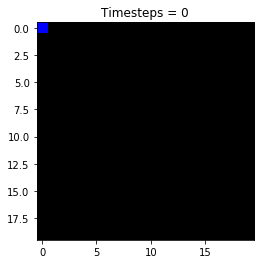

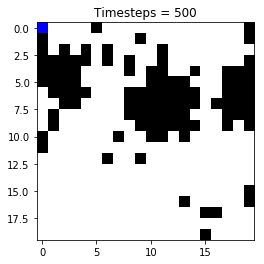

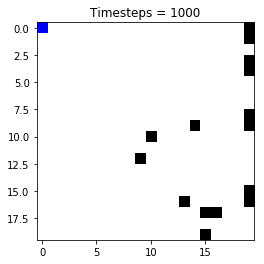

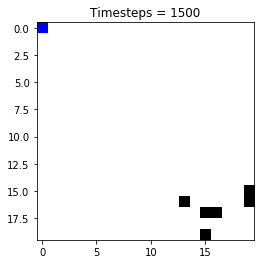

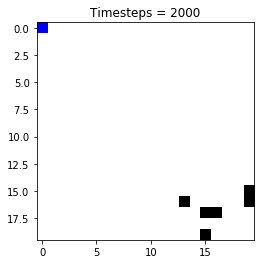

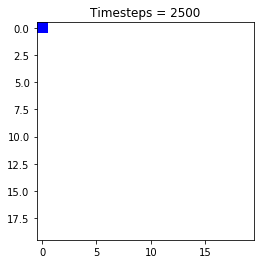

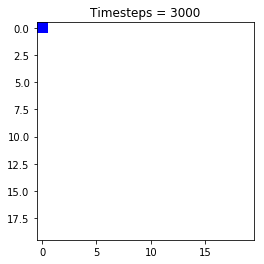

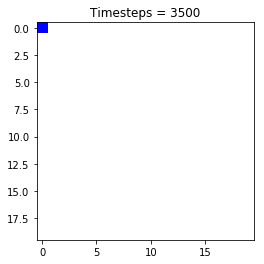

1.0

In [25]:
DISPLAY = True
simulation = RoomSimulation(room_size=(20,20), room_type=ROOM_TYPE.EMPTY, num_obstacles = 100)
simulation.change_strategy('check_dirty')
simulation.simulate()
simulation.calc_cleaned_area()

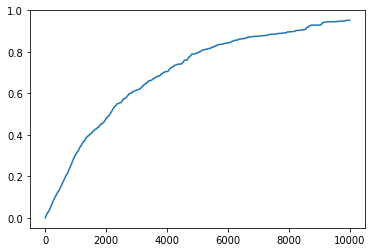

In [5]:
# Testing by running a single simulation
#

num_steps = 10000
roomba_simulation = RoomSimulation(room_size=(50,50), room_type=ROOM_TYPE.MESSY)
arr_cleaned_area = [roomba_simulation.calc_cleaned_area()]
arr_timesteps = [roomba_simulation.timesteps]
for i in range(num_steps):
    roomba_simulation.step()
    arr_cleaned_area.append(roomba_simulation.calc_cleaned_area())
    arr_timesteps.append(roomba_simulation.timesteps)
    
plt.plot(arr_timesteps, arr_cleaned_area)

In [6]:
DISPLAY = False 

def run_experiment(list_obstacles = [], num_simulations=100, num_steps=5000,
                   room_params={}, roomba_params={}, strategy='random_move'):
    
    '''
        Runs an experiment. Creates new obstacle if list_obstacles is not empty
        
        Input:
        
        * list_obstacles (list) The list of (x, y) coordinates for obstacles
            Default = []
        
        * num_simulations (int) The number of simulations. Default = 100
        
        * num_steps (int) The number of steps in each simulation. Default = 5000
        
        * room_params (dict) parameters for initializing room class. Default = {}
        
        * room_type (dict) parameters for initilializing Roomba Class. Default = {}
        
        * strategy (string) The strategy for moving roomba
        
        
        Output:
        
        * list of three lists
        
        * arr_final_cleaned_area (list) storing the percentage of area cleaned at the end of the simulation
        
        * arr_time_taken (list) Time taken to clean the whole area
        
        * arr_step_cleaned_area (list) of (list) storing percentage of area cleaned
            at each time step, for each simulations
    '''
    arr_final_cleaned_area = []
    arr_time_taken = []
    arr_step_cleaned_area = []
    
    for i in range(num_simulations):

        roomba_simulation = RoomSimulation(**room_params, roomba_params=roomba_params)
        
        if len(list_obstacles) > 0:
            # If there is an obstacle generates new obstacles
            roomba_simulation.generate_obstacles(list_obstacles)
            
        roomba_simulation.change_strategy(strategy)
        step_cleaned_area = []
        
        for _ in range(num_steps):
            roomba_simulation.step()
            step_cleaned_area.append(roomba_simulation.calc_cleaned_area())
        
        arr_final_cleaned_area.append(roomba_simulation.calc_cleaned_area())
        arr_step_cleaned_area.append(step_cleaned_area)
        
        if roomba_simulation.timesteps_for_complete_cleaning == 0:
            # if the room is not completely cleaned will store the number of timesteps
            arr_time_taken.append(roomba_simulation.timesteps)
        else:
            arr_time_taken.append(roomba_simulation.timesteps_for_complete_cleaning)
    
    # Display final room status
    print('--' * 20)
    print('Simulation Completed')
    return (arr_final_cleaned_area, arr_time_taken, arr_step_cleaned_area)



def plot_clean_steps(num_steps, sim_results, color='b', label=''):
    '''
        Plots the mean, and 95% confidence interval
        
        Input:
        
        num_steps (int) The number of timesteps it took
        
        sim_results (list) The list of list with percentage of area cleaned at each step
        
        color (string) The color of the plot. Default = 'b'
        
        label (string) The label of the plot. Default = ''
        
    '''
    time_steps = [i for i in range(num_steps)]
    sim_results = np.array(sim_results)
    arr_mean_clean = [np.mean(sim_results[:, i]) for i in range(num_steps)]
    arr_upper_bound_clean = [np.percentile(sim_results[:, i], 97.5) for i in range(num_steps)]
    arr_lower_bound_clean = [np.percentile(sim_results[:, i], 2.5) for i in range(num_steps)]
    plt.plot(time_steps, arr_mean_clean, color=color, label=label)
    plt.plot(time_steps, arr_upper_bound_clean, '--', color=color)
    plt.plot(time_steps, arr_lower_bound_clean, '--', color=color)

## Running experiment on an empty room with 20*20 room size

In [7]:
results_moore = {}

Running strategy::  random_move
----------------------------------------
Simulation Completed
Running strategy::  straight_and_random
----------------------------------------
Simulation Completed
Running strategy::  check_dirty
----------------------------------------
Simulation Completed


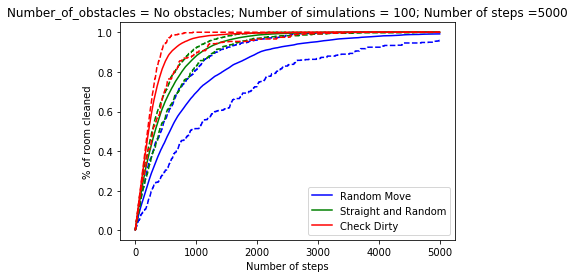

In [8]:
# Running Experiments in Moore neighborhood

strategies = ['random_move', 'straight_and_random', 'check_dirty']


# Parameters
num_steps = 5000
num_simulations = 100
num_obstacles = 100
room_size = (20,20)
room_params={'room_size':room_size, 
             'num_obstacles': num_obstacles,
             'room_type':ROOM_TYPE.EMPTY}
roomba_params={'neighborhood': "MOORE"}

results_moore['empty'] = {}

for strategy in strategies:
    print('Running strategy:: ', strategy)
    results_moore['empty'][strategy] = run_experiment(num_simulations=num_simulations, 
                                                         num_steps=num_steps,
                                                         strategy=strategy, 
                                                         room_params=room_params,
                                                         roomba_params=roomba_params)



# Plotting the results
plot_clean_steps(num_steps, results_moore['empty']['random_move'][2], color='b', label='Random Move')
plot_clean_steps(num_steps, results_moore['empty']['straight_and_random'][2], color='g', label='Straight and Random')
plot_clean_steps(num_steps, results_moore['empty']['check_dirty'][2], color='r', label='Check Dirty')
plt.title('Number_of_obstacles = {0}; Number of simulations = {1}; Number of steps ={2}'.format('No obstacles', 
                                                                                         num_simulations, 
                                                                                         num_steps))
plt.xlabel('Number of steps')
plt.ylabel('% of room cleaned')
plt.legend()

Running strategy::  random_move
----------------------------------------
Simulation Completed
Running strategy::  straight_and_random
----------------------------------------
Simulation Completed
Running strategy::  check_dirty
----------------------------------------
Simulation Completed


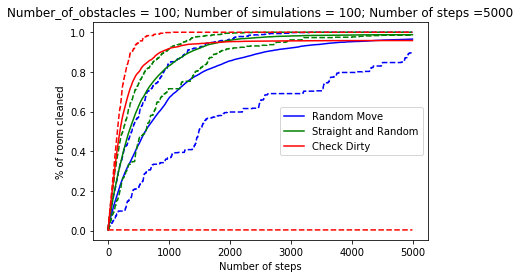

In [9]:
# Running Experiments in Moore neighborhood

strategies = ['random_move', 'straight_and_random', 'check_dirty']


# Parameters
num_steps = 5000
num_simulations = 100
num_obstacles = 100
room_size = (20,20)
room_params={'room_size':room_size, 
             'num_obstacles': num_obstacles,
             'room_type':ROOM_TYPE.MESSY}
roomba_params={'neighborhood': "MOORE"}

results_moore['messy'] = {}

for strategy in strategies:
    print('Running strategy:: ', strategy)
    results_moore['messy'][strategy] = run_experiment(num_simulations=num_simulations, 
                                                         num_steps=num_steps,
                                                         strategy=strategy, 
                                                         room_params=room_params,
                                                         roomba_params=roomba_params)



# Plotting the results
plot_clean_steps(num_steps, results_moore['messy']['random_move'][2], color='b', label='Random Move')
plot_clean_steps(num_steps, results_moore['messy']['straight_and_random'][2], color='g', label='Straight and Random')
plot_clean_steps(num_steps, results_moore['messy']['check_dirty'][2], color='r', label='Check Dirty')
plt.title('Number_of_obstacles = {0}; Number of simulations = {1}; Number of steps ={2}'.format(num_obstacles, 
                                                                                         num_simulations, 
                                                                                         num_steps))
plt.xlabel('Number of steps')
plt.ylabel('% of room cleaned')
plt.legend()


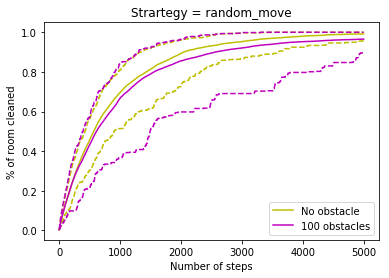

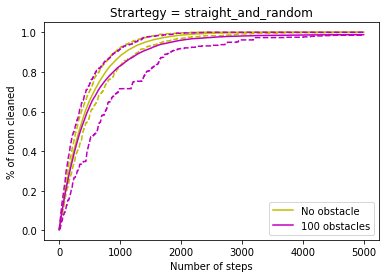

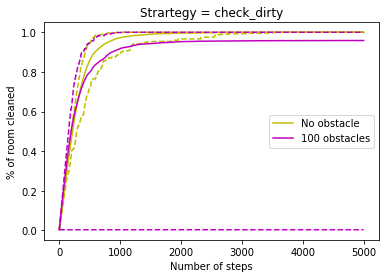

In [10]:
# Plotting the difference for each strategy

strategies = ['random_move', 'straight_and_random', 'check_dirty']

for strategy in strategies: 
    plot_clean_steps(num_steps, results_moore['empty'][strategy][2], color='y', label='No obstacle')
    plot_clean_steps(num_steps, results_moore['messy'][strategy][2], color='m', label='{0} obstacles'.format(num_obstacles))
    plt.title('Strartegy = {0}'.format(strategy))
    plt.xlabel('Number of steps')
    plt.ylabel('% of room cleaned')
    plt.legend()
    plt.legend()
    plt.show()

## Experimenting using Von Neumann neighborhood

In [11]:
# Dict to store results for Von Neumann neighborhood
results_von_neumann = {}

Running strategy::  random_move
----------------------------------------
Simulation Completed
Running strategy::  straight_and_random
----------------------------------------
Simulation Completed
Running strategy::  check_dirty
----------------------------------------
Simulation Completed



Neighborhood:  VON NEUMANN
Number of Obstacles:  0


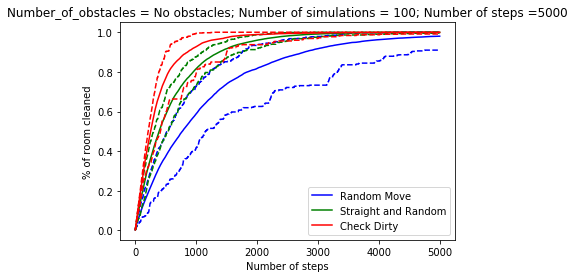

In [12]:
strategies = ['random_move', 'straight_and_random', 'check_dirty']


# Parameters
num_steps = 5000
num_simulations = 100
num_obstacles = 0
room_size = (20,20)
room_params={'room_size':room_size, 
             'num_obstacles': num_obstacles,
             'room_type':ROOM_TYPE.EMPTY}
roomba_params={'neighborhood': "VON NEUMANN"}


results_von_neumann['empty'] = {}

for strategy in strategies:
    print('Running strategy:: ', strategy)
    results_von_neumann['empty'][strategy] = run_experiment(num_simulations=num_simulations, 
                                                         num_steps=num_steps,
                                                         strategy=strategy, 
                                                         room_params=room_params,
                                                         roomba_params=roomba_params)



print('\n\n')
print('Neighborhood: ', 'VON NEUMANN')
print('Number of Obstacles: ', num_obstacles)
# Plotting the results
plot_clean_steps(num_steps, results_von_neumann['empty']['random_move'][2], color='b', label='Random Move')
plot_clean_steps(num_steps, results_von_neumann['empty']['straight_and_random'][2], color='g', label='Straight and Random')
plot_clean_steps(num_steps, results_von_neumann['empty']['check_dirty'][2], color='r', label='Check Dirty')
plt.title('Number_of_obstacles = {0}; Number of simulations = {1}; Number of steps ={2}'.format('No obstacles', 
                                                                                         num_simulations, 
                                                                                         num_steps))
plt.xlabel('Number of steps')
plt.ylabel('% of room cleaned')
plt.legend()

Running strategy::  random_move
----------------------------------------
Simulation Completed
Running strategy::  straight_and_random
----------------------------------------
Simulation Completed
Running strategy::  check_dirty
----------------------------------------
Simulation Completed



Neighborhood:  VON NEUMANN
Number of Obstacles:  100


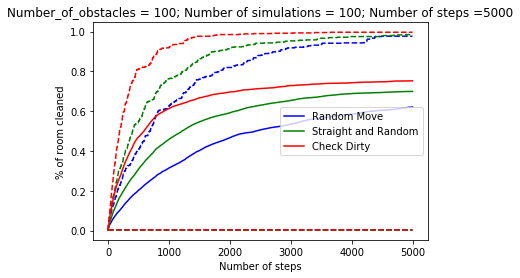

In [13]:
strategies = ['random_move', 'straight_and_random', 'check_dirty']


# Parameters
num_steps = 5000
num_simulations = 100
num_obstacles = 100
room_size = (20,20)
room_params={'room_size':room_size, 
             'num_obstacles': num_obstacles,
             'room_type':ROOM_TYPE.MESSY}
roomba_params={'neighborhood': "VON NEUMANN"}

results_von_neumann['messy'] = {}

for strategy in strategies:
    print('Running strategy:: ', strategy)
    results_von_neumann['messy'][strategy] = run_experiment(num_simulations=num_simulations, 
                                                         num_steps=num_steps,
                                                         strategy=strategy, 
                                                         room_params=room_params,
                                                         roomba_params=roomba_params)


print('\n\n')
print('Neighborhood: ', 'VON NEUMANN')
print('Number of Obstacles: ', num_obstacles)

# Plotting the results
plot_clean_steps(num_steps, results_von_neumann['messy']['random_move'][2], color='b', label='Random Move')
plot_clean_steps(num_steps, results_von_neumann['messy']['straight_and_random'][2], color='g', label='Straight and Random')
plot_clean_steps(num_steps, results_von_neumann['messy']['check_dirty'][2], color='r', label='Check Dirty')
plt.title('Number_of_obstacles = {0}; Number of simulations = {1}; Number of steps ={2}'.format(num_obstacles, 
                                                                                         num_simulations, 
                                                                                         num_steps))
plt.xlabel('Number of steps')
plt.ylabel('% of room cleaned')
plt.legend()

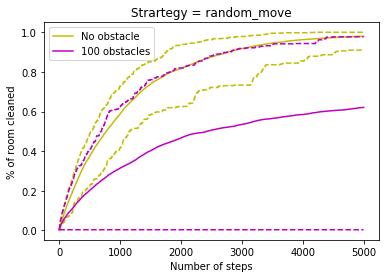

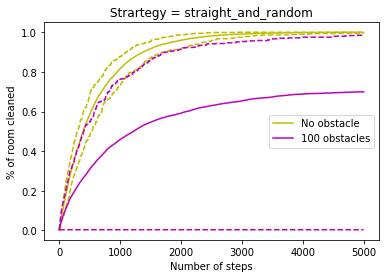

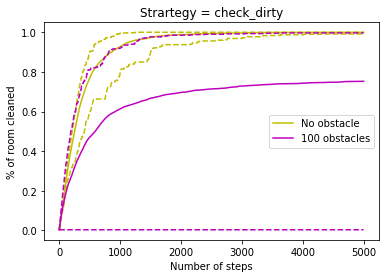

In [14]:
# Plotting the difference for each strategy

strategies = ['random_move', 'straight_and_random', 'check_dirty']

for strategy in strategies: 
    plot_clean_steps(num_steps, results_von_neumann['empty'][strategy][2], color='y', label='No obstacle')
    plot_clean_steps(num_steps, results_von_neumann['messy'][strategy][2], color='m', label='{0} obstacles'.format(num_obstacles))
    plt.title('Strartegy = {0}'.format(strategy))
    plt.xlabel('Number of steps')
    plt.ylabel('% of room cleaned')
    plt.legend()
    plt.legend()
    plt.show()

## Experimenting with my room layout

My room layout


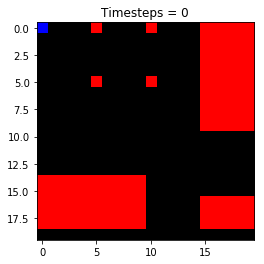

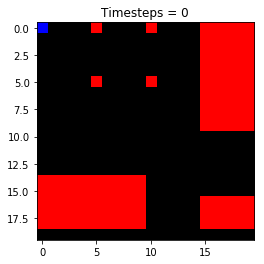

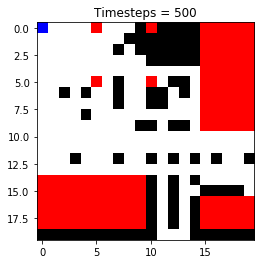

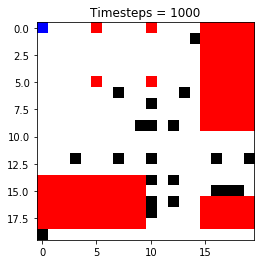

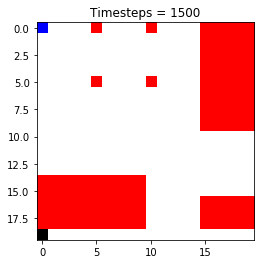

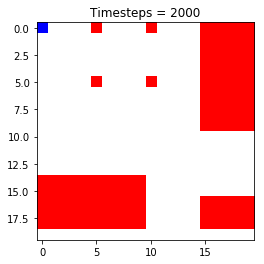

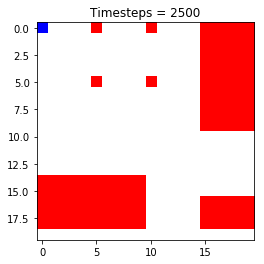

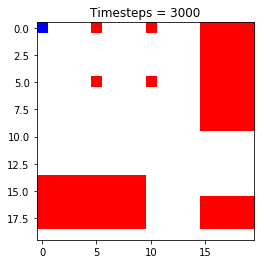

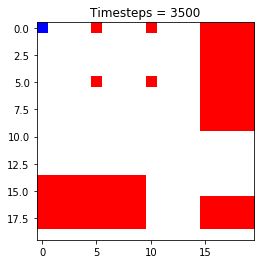

In [15]:
DISPLAY = True

def create_obstacle(length = 10, width = 5, x_start= 0, y_start = 15):
    matrix_item = []
    for i in range(length):
        for j in range(width):
            matrix_item.append((x_start + i, y_start + j))
    return matrix_item


# Tables will only create obstacles in tables
coords_table_leg = [(0, 5), (0, 10), (5, 5), (5, 10)]

# Combining and creating bed, closet and table
list_obstacles = [*create_obstacle(), 
                  *create_obstacle(5, 10, 14, 0),
                  *create_obstacle(3, 5, 16, 15),
                  *coords_table_leg
                 ]

# Testing creating objects and running simulation
print('My room layout')
room_size = 20
sim = RoomSimulation(room_size=(room_size,room_size), room_type=ROOM_TYPE.EMPTY)
sim.generate_obstacles(list_obstacles)
sim.display()
sim.simulate()

Running strategy::  random_move
----------------------------------------
Simulation Completed
Running strategy::  straight_and_random
----------------------------------------
Simulation Completed
Running strategy::  check_dirty
----------------------------------------
Simulation Completed



Neighborhood:  VON NEUMANN


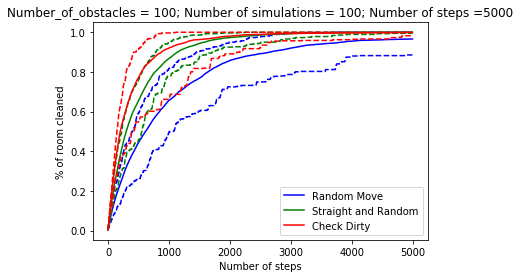

In [16]:
strategies = ['random_move', 'straight_and_random', 'check_dirty']
DISPLAY = False

# Parameters
num_steps = 5000
num_simulations = 100
room_size = (20,20)
room_params={'room_size':room_size}
roomba_params={'neighborhood': "VON NEUMANN"}

results_von_neumann['my_room'] = {}

for strategy in strategies:
    print('Running strategy:: ', strategy)
    results_von_neumann['my_room'][strategy] = run_experiment(list_obstacles,num_simulations=num_simulations, 
                                                             num_steps=num_steps,
                                                             strategy=strategy, 
                                                             room_params=room_params,
                                                             roomba_params=roomba_params)


print('\n\n')
print('Neighborhood: ', 'VON NEUMANN')

# Plotting the results
plot_clean_steps(num_steps, results_von_neumann['my_room']['random_move'][2], color='b', label='Random Move')
plot_clean_steps(num_steps, results_von_neumann['my_room']['straight_and_random'][2], color='g', label='Straight and Random')
plot_clean_steps(num_steps, results_von_neumann['my_room']['check_dirty'][2], color='r', label='Check Dirty')
plt.title('Number_of_obstacles = {0}; Number of simulations = {1}; Number of steps ={2}'.format(num_obstacles, 
                                                                                         num_simulations, 
                                                                                         num_steps))
plt.xlabel('Number of steps')
plt.ylabel('% of room cleaned')
plt.legend()

Running strategy::  random_move
----------------------------------------
Simulation Completed
Running strategy::  straight_and_random
----------------------------------------
Simulation Completed
Running strategy::  check_dirty
----------------------------------------
Simulation Completed



Neighborhood:  MOORE
Layout: MY ROOM


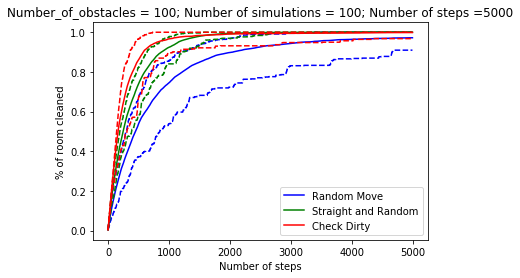

In [18]:
strategies = ['random_move', 'straight_and_random', 'check_dirty']
DISPLAY = False

# Parameters
num_steps = 5000
num_simulations = 100
room_size = (20,20)
room_params={'room_size':room_size}
roomba_params={'neighborhood': "MOORE"}

results_moore['my_room'] = {}

for strategy in strategies:
    print('Running strategy:: ', strategy)
    results_moore['my_room'][strategy] = run_experiment(list_obstacles,num_simulations=num_simulations, 
                                                             num_steps=num_steps,
                                                             strategy=strategy, 
                                                             room_params=room_params,
                                                             roomba_params=roomba_params)


print('\n\n')
print('Neighborhood: ', 'MOORE')
print('Layout: MY ROOM')

# Plotting the results
plot_clean_steps(num_steps, results_moore['my_room']['random_move'][2], color='b', label='Random Move')
plot_clean_steps(num_steps, results_moore['my_room']['straight_and_random'][2], color='g', label='Straight and Random')
plot_clean_steps(num_steps, results_moore['my_room']['check_dirty'][2], color='r', label='Check Dirty')
plt.title('Number_of_obstacles = {0}; Number of simulations = {1}; Number of steps ={2}'.format(num_obstacles, 
                                                                                         num_simulations, 
                                                                                         num_steps))
plt.xlabel('Number of steps')
plt.ylabel('% of room cleaned')
plt.legend()

## Running Rooma in Dana's room layout

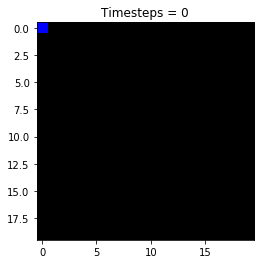

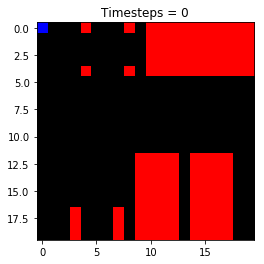

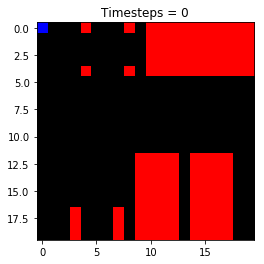

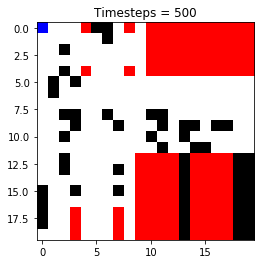

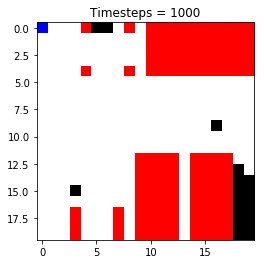

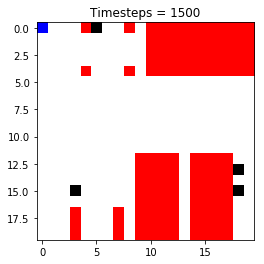

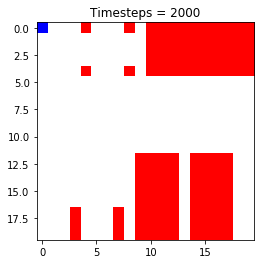

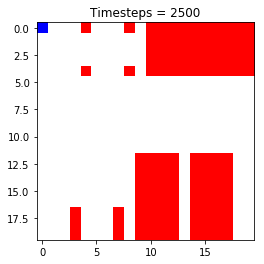

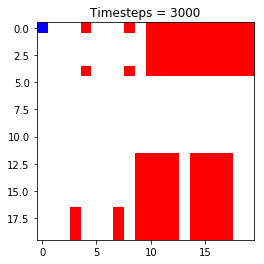

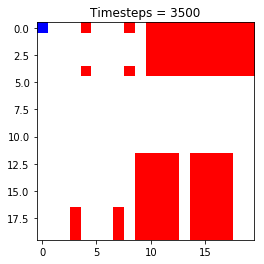

In [19]:
DISPLAY = True

def create_obstacle(length = 10, width = 5, x_start= 0, y_start = 15):
    matrix_item = []
    for i in range(length):
        for j in range(width):
            matrix_item.append((x_start + i, y_start + j))
    return matrix_item


# Tables will only create obstacles in tables
coords_table1 = [(0, 4), (0, 8), (4, 4), (4, 8)]
coords_table2 = [(17, 3), (18, 3), (19, 3),
                 (17, 7), (18, 7), (19, 7)
                ]

# Combining and creating bed, closet and table
list_obstacles_dana_room = [*create_obstacle(5, 10, 0, 10), 
                  *create_obstacle(8, 4, 12, 9),
                  *create_obstacle(8, 4, 12, 14),
                  *coords_table1,
                  *coords_table2
                 ]

# Testing creating objects and running simulation
room_size = 20
sim = RoomSimulation(room_size=(room_size,room_size), room_type=ROOM_TYPE.EMPTY)
sim.display()
sim.generate_obstacles(list_obstacles_dana_room)
sim.display()
sim.simulate()

Running strategy::  random_move
----------------------------------------
Simulation Completed
Running strategy::  straight_and_random
----------------------------------------
Simulation Completed
Running strategy::  check_dirty
----------------------------------------
Simulation Completed



Neighborhood:  VON NEUMANN
Layout: DANA's ROOM


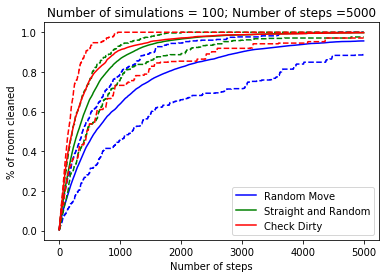

In [20]:
strategies = ['random_move', 'straight_and_random', 'check_dirty']
DISPLAY = False

# Parameters
num_steps = 5000
num_simulations = 100
room_size = (20,20)
room_params={'room_size':room_size}
roomba_params={'neighborhood': "VON NEUMANN"}

results_von_neumann['dana_room'] = {}

for strategy in strategies:
    print('Running strategy:: ', strategy)
    results_von_neumann['dana_room'][strategy] = run_experiment(list_obstacles_dana_room,
                                                              num_simulations=num_simulations, 
                                                              num_steps=num_steps,
                                                             strategy=strategy, 
                                                             room_params=room_params,
                                                             roomba_params=roomba_params)


print('\n\n')
print('Neighborhood: ', 'VON NEUMANN')
print('Layout: DANA\'s ROOM')

# Plotting the results
plot_clean_steps(num_steps, results_von_neumann['dana_room']['random_move'][2], color='b', label='Random Move')
plot_clean_steps(num_steps, results_von_neumann['dana_room']['straight_and_random'][2], color='g', label='Straight and Random')
plot_clean_steps(num_steps, results_von_neumann['dana_room']['check_dirty'][2], color='r', label='Check Dirty')
plt.title('Number of simulations = {0}; Number of steps ={1}'.format(num_simulations, num_steps))
plt.xlabel('Number of steps')
plt.ylabel('% of room cleaned')
plt.legend()

Running strategy::  random_move
----------------------------------------
Simulation Completed
Running strategy::  straight_and_random
----------------------------------------
Simulation Completed
Running strategy::  check_dirty
----------------------------------------
Simulation Completed



Neighborhood:  MOORE
Layout: DANA's ROOM


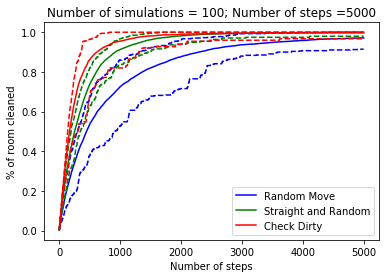

In [21]:
strategies = ['random_move', 'straight_and_random', 'check_dirty']
DISPLAY = False

# Parameters
num_steps = 5000
num_simulations = 100
room_size = (20,20)
room_params={'room_size':room_size}
roomba_params={'neighborhood': "MOORE"}

results_moore['dana_room'] = {}

for strategy in strategies:
    print('Running strategy:: ', strategy)
    results_moore['dana_room'][strategy] = run_experiment(list_obstacles_dana_room,
                                                          num_simulations=num_simulations, 
                                                         num_steps=num_steps,
                                                         strategy=strategy, 
                                                         room_params=room_params,
                                                         roomba_params=roomba_params)


print('\n\n')
print('Neighborhood: ', 'MOORE')
print('Layout: DANA\'s ROOM')

# Plotting the results
plot_clean_steps(num_steps, results_moore['dana_room']['random_move'][2], color='b', label='Random Move')
plot_clean_steps(num_steps, results_moore['dana_room']['straight_and_random'][2], color='g', label='Straight and Random')
plot_clean_steps(num_steps, results_moore['dana_room']['check_dirty'][2], color='r', label='Check Dirty')
plt.title('Number of simulations = {0}; Number of steps ={1}'.format(num_simulations,num_steps))
plt.xlabel('Number of steps')
plt.ylabel('% of room cleaned')
plt.legend()

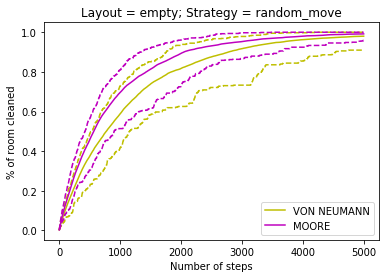

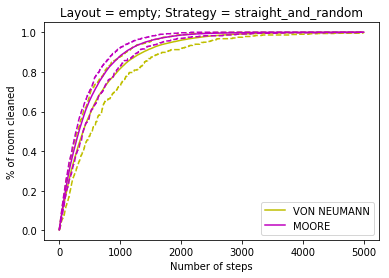

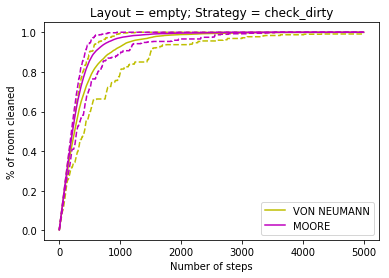

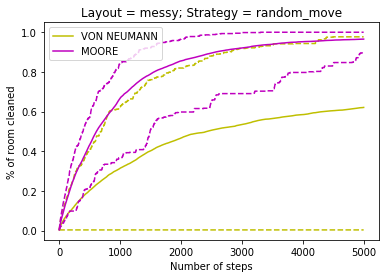

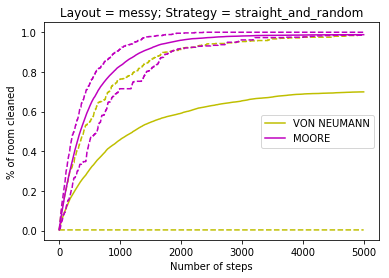

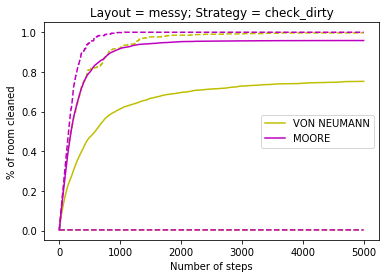

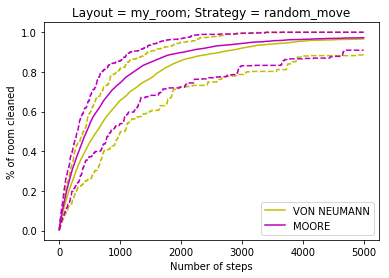

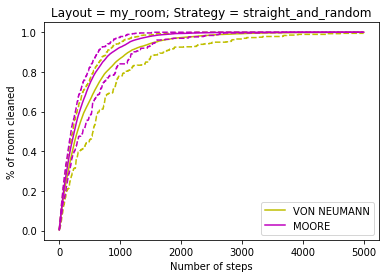

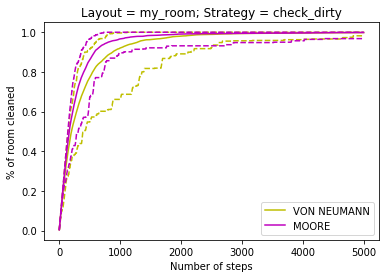

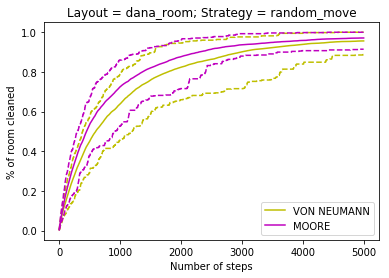

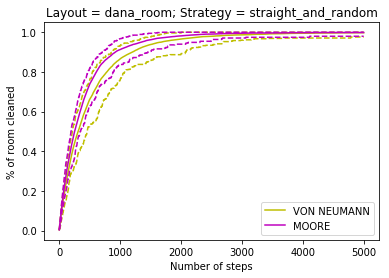

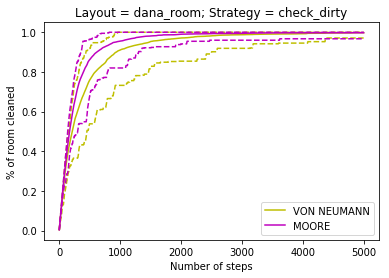

In [32]:
# Plotting the difference for each strategy

strategies = ['random_move', 'straight_and_random', 'check_dirty']

for key in results_moore:
    for strategy in strategies: 
        plot_clean_steps(num_steps, results_von_neumann[key][strategy][2], color='y', label='VON NEUMANN')
        plot_clean_steps(num_steps, results_moore[key][strategy][2], color='m', label='MOORE')
        plt.title('Layout = {0}; Strategy = {1}'.format(key, strategy))
        plt.xlabel('Number of steps')
        plt.ylabel('% of room cleaned')
        plt.legend()
        plt.show()

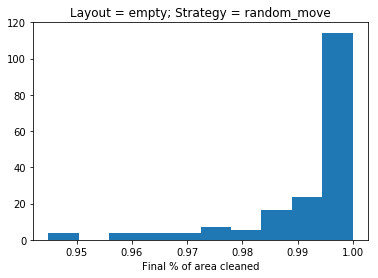

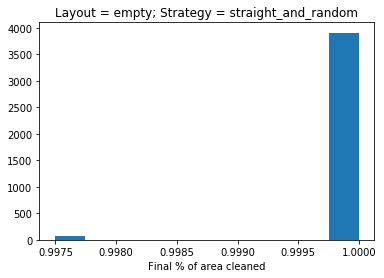

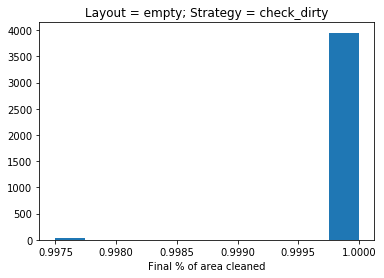

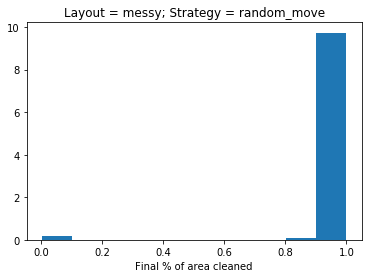

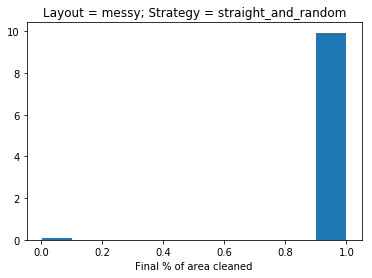

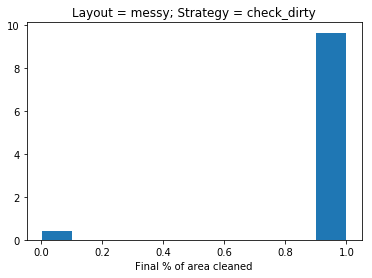

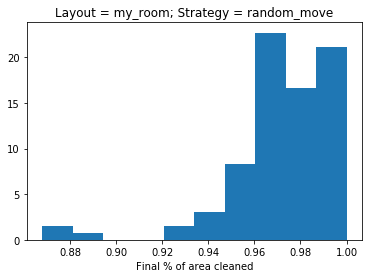

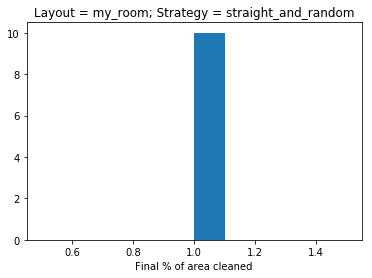

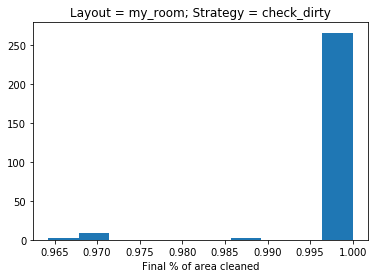

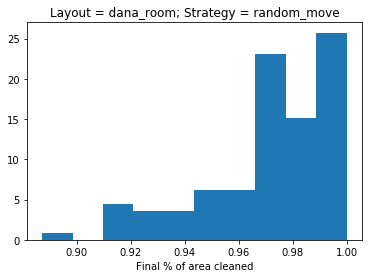

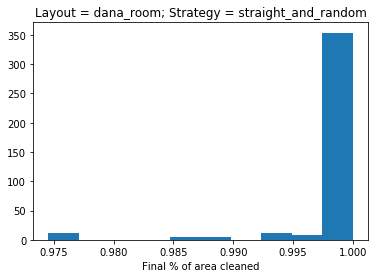

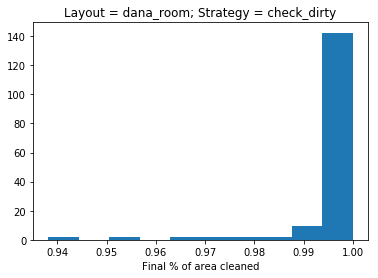

In [44]:
# Plotting the histogram for each strategy

strategies = ['random_move', 'straight_and_random', 'check_dirty']

for key in results_moore:
    for strategy in strategies: 
        plt.hist(results_moore[key][strategy][0], density=True)
        plt.title('Layout = {0}; Strategy = {1}'.format(key, strategy))
        plt.xlabel('Final % of area cleaned')
        plt.show()

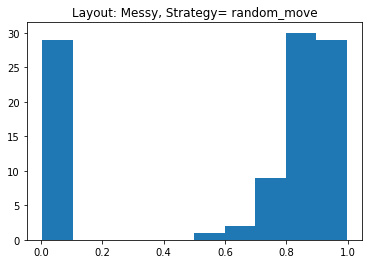

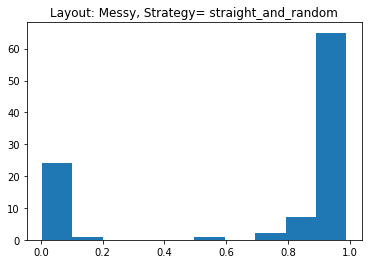

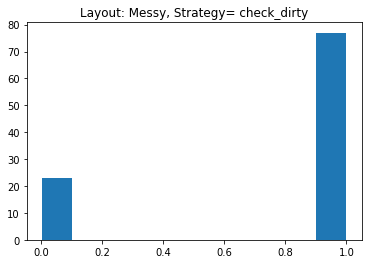

In [46]:
for strategy in strategies:
    plt.hist(results_von_neumann['messy'][strategy][0])
    plt.title('Layout: Messy, Strategy= {0}'.format(strategy))
    plt.show()